## Dictionary and Imports

In [531]:
# Dictionary of users and passwords registered
AUTHORIZED_USERS = {
    "Arianna": "falcon",
    "Andre": "tiger"
}

In [2]:
import os
import random
import numpy as np
import librosa
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import speech_recognition as sr

from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

## Voice acquisition and processing module
The user speaks into the microphone.
The signal is preprocessed to remove noise and normalized.

Alternatively, one of the audio files already present in the folder can be used.
The signal is processed in the same way.

In [3]:
# function to apply a band-pass filter
def preprocess_audio(file_path, low_cutoff=100, high_cutoff=3000):
    signal, sr = librosa.load(file_path, sr=16000)
    normalized_signal = librosa.util.normalize(signal)

    nyquist = 0.5 * sr
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    
    b, a = butter(5, [low, high], btype='band')
    filtered_signal = lfilter(b, a, normalized_signal)
    return filtered_signal, sr  

# function to acquire audio from "test" folder
def choose_test_audio(n):
    test_folder = "./dataset/test" 
    audio_files = [f for f in os.listdir(test_folder) if f.endswith('.wav')]

    if not audio_files:
        raise FileNotFoundError("No audio files found in the 'test' folder.")

    if n == 0:  # Se n == 0, random choice
        selected_file = random.choice(audio_files)
    else:  # otherwise, choose n-th file
        if n > len(audio_files):
            raise IndexError(f"The test folder contains only {len(audio_files)} files.")
        audio_files.reverse()
        selected_file = audio_files[n - 1]

    file_path = os.path.join(test_folder, selected_file)
    return file_path

# function to extract mfcc
def extract_mfcc(file_path):
    [y, sr] = preprocess_audio(file_path)
 
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)  # MFCC mean on all time windows 
    mfcc_std = np.std(mfcc, axis=1)
    embedding = np.concatenate((mfcc_mean, mfcc_std))

    return embedding, y

## Features extraction

Generates a unique numerical embedding from voice characteristics to identify the speaker. 

Returns the estimated identity ("Arianna", "Andre", or "Unauthorized").

In [4]:
# function to generate sentence file paths
def generate_sentence_file_paths(base_name, num_files):
    return [f"dataset/registered/sentences/{base_name}_sen{i}.wav" for i in range(1, num_files + 1)]

def create_labels_and_features(file_paths, speaker_id):
    features = []
    labels = []
    
    for file_path in file_paths:
        [embedding, y] = extract_mfcc(file_path)  
        features.append(embedding)
        labels.append(speaker_id) 
    
    return np.array(features), np.array(labels)

arianna_files = generate_sentence_file_paths('arianna', 23)
andre_files = generate_sentence_file_paths('andre', 22) 

# Labels creation: Arianna (speaker_id = 0), André (speaker_id = 1)
arianna_features, arianna_labels = create_labels_and_features(arianna_files, speaker_id=0)
andre_features, andre_labels = create_labels_and_features(andre_files, speaker_id=1)

# Features unified
X_train = np.vstack([arianna_features, andre_features])  
y_train = np.hstack([arianna_labels, andre_labels])

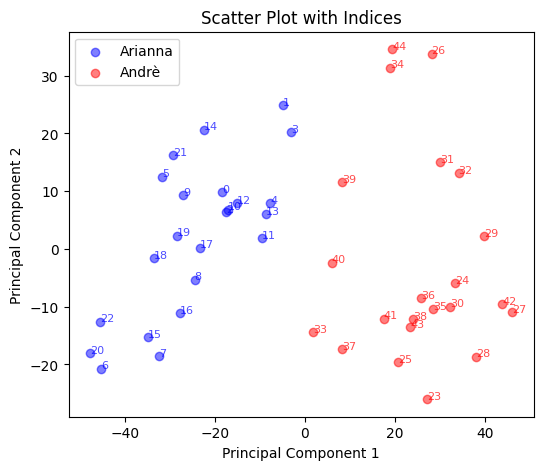

In [5]:
# PCA to reduce informations in 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Supponendo che X_pca, y_train siano definiti
plt.figure(figsize=(6, 5))

# Scatter plot per i punti con etichetta 0
plt.scatter(X_pca[y_train == 0][:, 0], X_pca[y_train == 0][:, 1], label='Arianna', color='blue', alpha=0.5)
plt.scatter(X_pca[y_train == 1][:, 0], X_pca[y_train == 1][:, 1], label='Andrè', color='red', alpha=0.5)

# Annotazioni per i punti con etichetta 0
for i in range(len(X_pca)):
    if y_train[i] == 0:
        plt.text(X_pca[i, 0], X_pca[i, 1], str(i), fontsize=8, color='blue', alpha=0.7)

# Annotazioni per i punti con etichetta 1
for i in range(len(X_pca)):
    if y_train[i] == 1:
        plt.text(X_pca[i, 0], X_pca[i, 1], str(i), fontsize=8, color='red', alpha=0.7)

plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot with Indices')
plt.show()

## Model training and Speaker recognition 

Recognizes who is speaking regardless of content.
Focus on the physical and behavioural properties of the voice.

In [6]:
# initialize and train the model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)   # train the model, result: iperplane

path_test_audio = choose_test_audio(0)
print(path_test_audio)
test_embedding, test_audio = extract_mfcc(path_test_audio)

probabilities = model.predict_proba([test_embedding])[0]
prediction = np.argmax(probabilities)  # Speaker predicted
confidence = probabilities[prediction]  # Confidence

predicted_speaker = 'Arianna' if prediction==0 else 'Andre'
print(f"Predicted speaker: {predicted_speaker}, with confidence: {confidence}")

threshold = 0.70 
if confidence < threshold:
    print("Speaker unknown...")
else:
    print(f"{predicted_speaker}, speaker recognized!")

./dataset/test/cristina_falcon.wav
Predicted speaker: Andre, with confidence: 0.67
Speaker unknown...


## Password recognition

The system checks that the person is using their own password and not someone else's. The spoken password is transcribed into text and compared with the registered password of the identified user. To prevent transcription errors, the system also performs a direct audio verification, comparing the spoken sounds with the stored acoustic model of the password.

In [8]:
def recognize_password(path_test_audio, prediction):
    recognizer = sr.Recognizer()
    correct_password = 'Falcon' if prediction==0 else 'Tiger'

    with sr.AudioFile(path_test_audio) as source:
            test_audio = recognizer.record(source)

    try:
        # Use Google Web Speech API to trascript in text
        recognized_text = recognizer.recognize_google(test_audio)
        print(f"Recognized text: {recognized_text}")

        similarity = fuzz.ratio(recognized_text.lower(), correct_password.lower())

        # Confronta la parola riconosciuta con la password
        if similarity >= 80:
            print("Password recognized successfully!")
            print("Access allowed!")
        else:
            print("Password does not match...")
            print("Access denied.")
    
    except sr.UnknownValueError:
        print("Sorry, could not understand the audio.")
    except sr.RequestError as e:
        print(f"Error with the speech recognition service: {e}")

recognize_password(path_test_audio, prediction)

Recognized text: falcon
Password does not match...
Access denied.
